# DMML-03

Modelltanítás; döntési fák; `scikit-learn`; modellek kiértékelése:
hold-out módszer és keresztvalidáció; hiperparaméter-optimalizálás:
random search, grid search, Optuna csomag.

Apagyi Dávid  
2025-09-25

**Honlap:** <a href="https://apagyidavid.web.elte.hu/2025-2026-1/dmml"
target="_blank">apagyidavid.web.elte.hu/2025-2026-1/dmml</a>

<a target="_blank" href="https://colab.research.google.com/github/dapagyi/dmml-web/blob/notebooks/dmml-03.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Döntési fák

## Felépítés

-   Fa, háromféle csúcs:
    -   gyökér (root),
    -   belcső csúcs (internal node),
    -   levél (leaf/terminal node).
-   Levelek címkézve vannak a célváltozó értékeivel.
-   A többi csúcsban kérdések a leíró változókról.

## Klasszifikáció döntési fával

-   Elindulunk a gyökérből:
    -   Ha levélbe érkezünk, akkor a levél címkéje a klasszifikált
        címke.
    -   Ha belső csúcsba érkezünk, kiértékeljük az ott lévő kérdést,
        aszerint megyünk tovább.

## Döntési fa építése (Hunt algoritmusa)

-   Gyökérből indulunk.
-   Egy adott $t$ csúcsra megnézzük, hogy a tanítóadat mely $D_t$
    részhalmaza jut le oda:
    -   Ha mindegyiknek valamilyen $y_t$ a címkéje, akkor $t$ levél, a
        címkéje $y_t$
    -   Ha több osztályba tartoznak, kiválasztunk egy $a_t$ leíró
        változót, és annak az értékei alapján létrehozzuk $t$ gyerekeit

## Hogyan válasszunk jó célváltozót?

Legyen $\mathbb{P}(y = y_i) = p_i$: egy adott csúcsba jutó adatpontok
hanyadrésze $y_i$ címkéjű.

-   Gini-index: $$G(y) = \sum_{i=1}^C p_i (1-p_i)$$
-   Entrópia vagy logloss: $$H(y) = -\sum_{i=1}^C p_i\log p_i$$

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree


df = pd.read_csv("https://apagyidavid.web.elte.hu/2025-2026-1/dmml/data/titanic.csv")
df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)
df.fillna({"Age": df["Age"].median(), "Embarked": df["Embarked"].mode()[0]}, inplace=True)

label_enc = LabelEncoder()
df["Sex"] = label_enc.fit_transform(df["Sex"])
df["Embarked"] = label_enc.fit_transform(df["Embarked"])

X = df.drop("Survived", axis=1)
y = df["Survived"]

X.head()

In [2]:
model = DecisionTreeClassifier()
model

In [3]:
model.fit(X, y)

'Misclassified: 18'

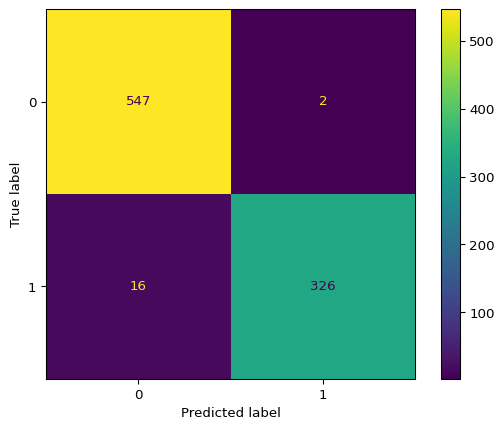

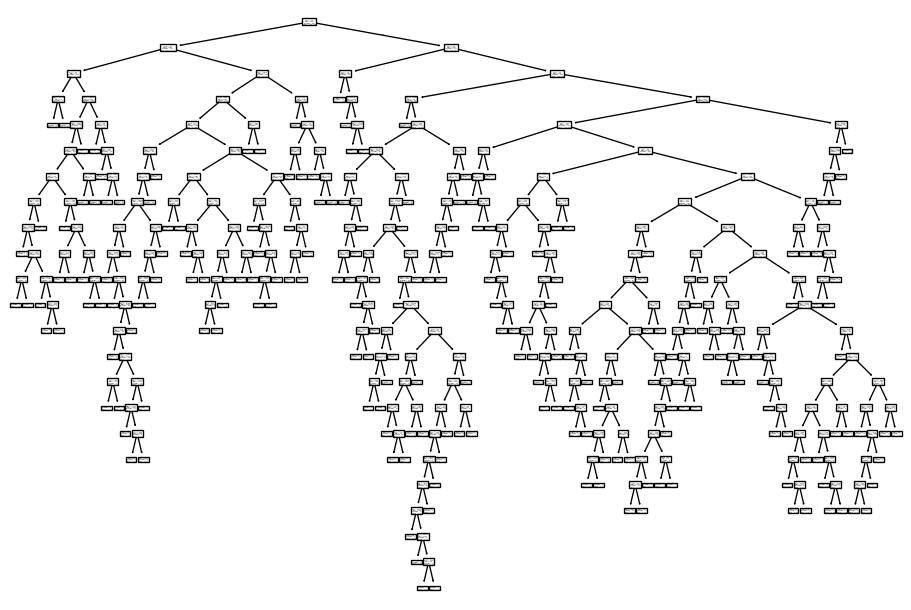

In [4]:
preds = model.predict(X)
display(f"Misclassified: {sum(abs(y - preds))}")
cm = confusion_matrix(y, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(model, ax=ax)
plt.show()

tree = model.tree_
tree.max_depth, len(X), tree.node_count, model.get_depth()

Az $n$ mélységű döntési fa (a példában 22) leveleinek maximális száma (a
fa *kapacitása*) $2^{n-1}$, ami *jóval nagyobb*, mint a mintahalmaz
mérete. Ebből adódóan a modell, ha más tényezők nem szólnának közbe,
akár az *egész adathalmazt* megtanulhatná. Ez a *túltanulás*
(*overfitting*) jelensége, ami miatt a modell az új, ismeretlen adatokon
már nem fog jól teljesíteni.

'Misclassified: 154'

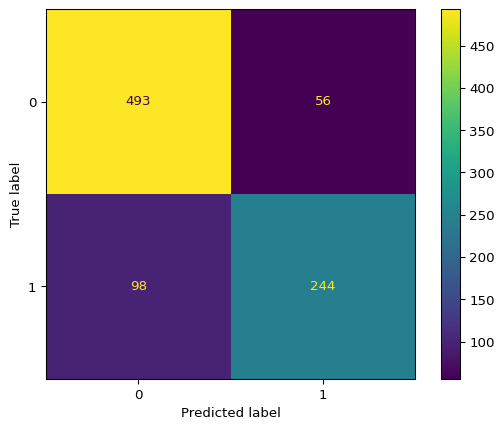

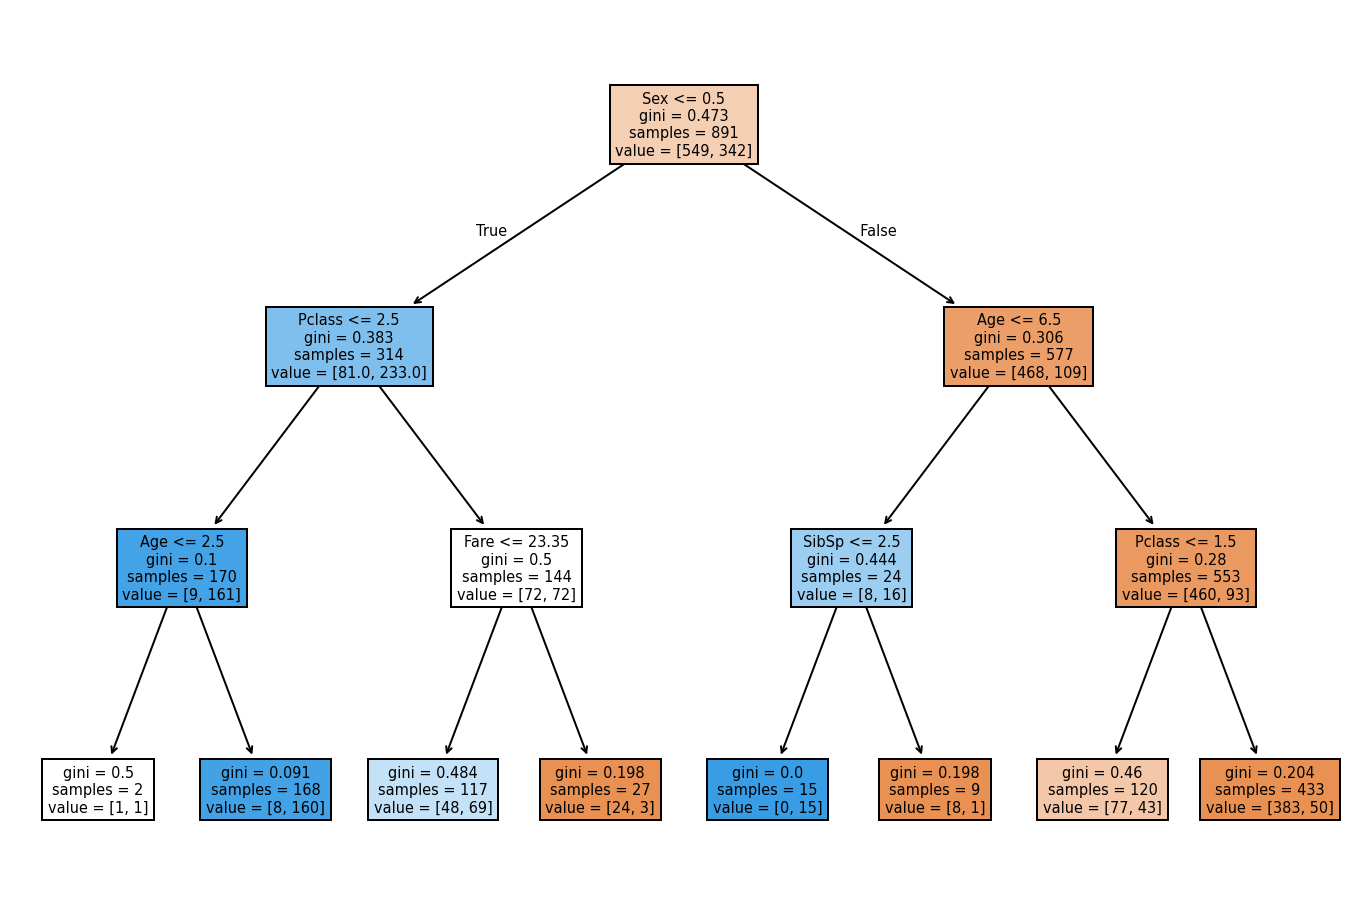

In [5]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X, y)
preds = model.predict(X)
display(f"Misclassified: {sum(abs(y - preds))}")
cm = confusion_matrix(y, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8), dpi=144)
plot_tree(model, ax=ax, feature_names=X.columns, filled=True)
plt.show()

tree = model.tree_
tree.max_depth, len(X), tree.node_count, model.get_depth()

# Modellek kiértékelése: hold-out módszer és keresztvalidáció

Hogyan tudunk kiértékelni egy modellt, és megbecsülni a teljesítményét
ismeretlen adatokon? Erre nyújt megoldást a *validáció*.

Ennel az egyik legfontosabb felhasználása (a túltanulás elkerülése
mellett) a *hiperparaméter-optimalizálás*, amikor a modellünk
hiperparamétereit szeretnénk a lehető legjobban beállítani. Az alábbi
példák egy döntési fa `max_depth` hiperparaméterének kiválasztását
mutatják be.

A validáció a két legelterjedtebb módja a *hold-out módszer* és a
*keresztvalidáció* (*cross-validation*).

## Hold-out módszer

A tanító adathalmazt felosztjuk egy tanító és egy validációs halmazra. A
modellt a tanító halmazon tanítjuk, majd a validációs halmazon
kiértékeljük.

In [6]:
records = []
params = {"criterion": "gini", "min_samples_split": 5}
seed = 42

for max_depth in range(2, 30):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

    model = DecisionTreeClassifier(max_depth=max_depth, **params, random_state=seed)
    model.fit(X_train, y_train)
    train_score = f1_score(y_train, model.predict(X_train))
    val_score = f1_score(y_val, model.predict(X_val))

    records.append({"max_depth": max_depth, "train_f1_score": train_score, "val_f1_score": val_score})

metrics = pd.DataFrame().from_records(records)

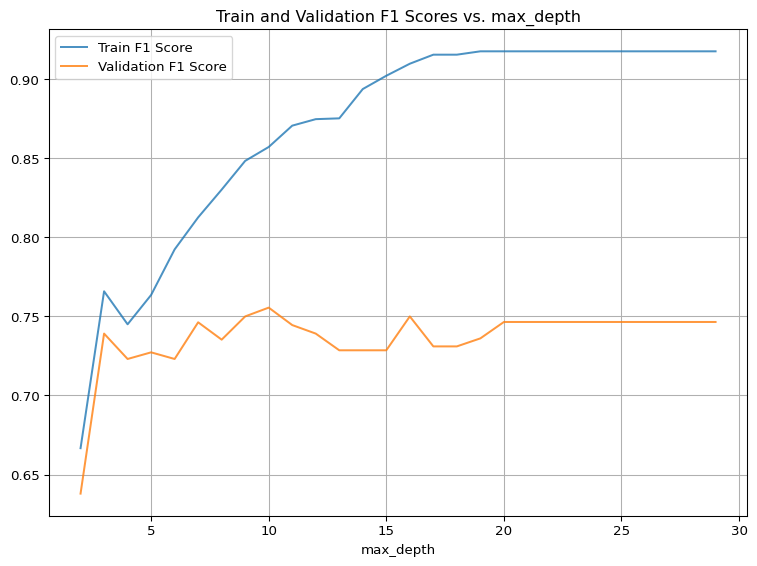

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
metrics.groupby("max_depth")["train_f1_score"].agg(["mean", "std"]).plot(
    y="mean", grid=True, ax=ax, label="Train F1 Score", alpha=0.8
)
metrics.groupby("max_depth")["val_f1_score"].agg(["mean", "std"]).plot(
    y="mean", grid=True, ax=ax, label="Validation F1 Score", alpha=0.8
)
ax.set_title("Train and Validation F1 Scores vs. max_depth")
fig.tight_layout()
plt.show()

## Keresztvalidáció

Az előzőnél valamivel kifinomultabb módszer a keresztvalidáció.
Felosztjuk a tanító adathalmazt $k$ részre (*fold*). Minden egyes részre
külön-külön elvégezzük a következő lépéseket:

1.  Az adott részt használjuk validációs halmazként.
2.  A többi ($k-1$ darab) részt egyesítjük, és ezt használjuk tanító
    halmazként.
3.  A modellt a tanító halmazon tanítjuk, majd a validációs halmazon
    kiértékeljük.

Ezáltal a $k$ darab metrikát kapunk, amelyeket utána aggregálhatunk.

Sokféle változata van aszerint, hogy hogyan osztjuk fel az adatokat:

-   <a href="https://scikit-learn.org/stable/modules/cross_validation.html"
    target="_blank">3.1. Cross-validation: evaluating estimator
    performance</a>

In [8]:
records = []
params = {"criterion": "gini", "min_samples_split": 5}
seed = 42

for max_depth in range(2, 20):
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)

    for fold, (train_index, val_index) in enumerate(cv.split(X)):
        X_train, y_train = X.loc[train_index], y[train_index]
        X_val, y_val = X.loc[val_index], y[val_index]

        model = DecisionTreeClassifier(max_depth=max_depth, **params, random_state=seed)
        model.fit(X_train, y_train)
        train_score = f1_score(y_train, model.predict(X_train))
        val_score = f1_score(y_val, model.predict(X_val))

        records.append({"max_depth": max_depth, "fold": fold, "train_f1_score": train_score, "val_f1_score": val_score})

metrics = pd.DataFrame().from_records(records)

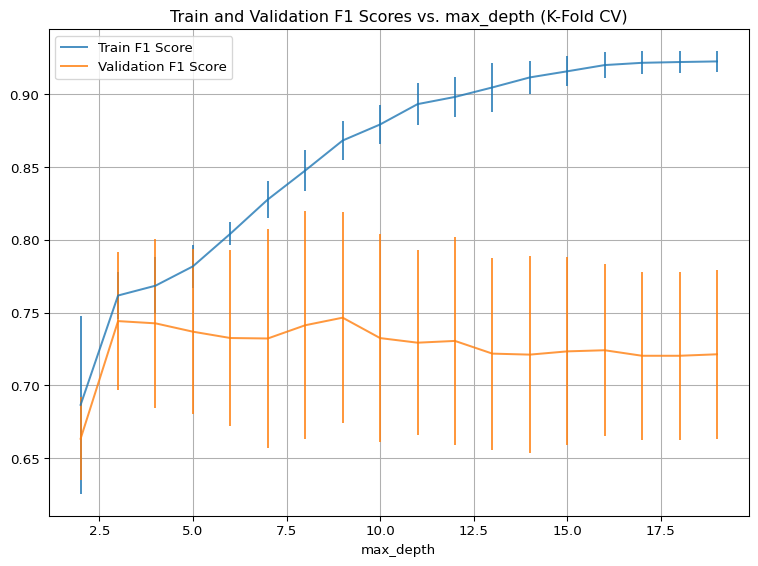

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
metrics.groupby("max_depth")["train_f1_score"].agg(["mean", "std"]).plot(
    y="mean", yerr="std", grid=True, ax=ax, label="Train F1 Score", alpha=0.8
)
metrics.groupby("max_depth")["val_f1_score"].agg(["mean", "std"]).plot(
    y="mean", yerr="std", grid=True, ax=ax, label="Validation F1 Score", alpha=0.8
)
ax.set_title("Train and Validation F1 Scores vs. max_depth (K-Fold CV)")
fig.tight_layout()
plt.show()

A fenti kézi implementáció helyett törekedjünk a beépített eszközök
használatára:

-   <a
    href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score"
    target="_blank"><code>sklearn.model_selection.cross_val_score</code></a>
-   <a
    href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate"
    target="_blank"><code>sklearn.model_selection.cross_validate</code></a>

Ezek részletesebb használatáról a szakasz elején lévő linken
olvashatunk.

A fentiekhez hasonló ábrákat beépített függvényekkel is készíthetünk:

-   <a href="https://scikit-learn.org/stable/modules/learning_curve.html"
    target="_blank">3.5. Validation curves: plotting scores to evaluate
    models</a>
-   <a
    href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ValidationCurveDisplay.html"
    target="_blank"><code>class sklearn.model_selection.ValidationCurveDisplay</code></a>
-   <a
    href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html#sklearn.model_selection.validation_curve"
    target="_blank"><code>sklearn.model_selection.validation_curve</code></a>
-   <a
    href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html"
    target="_blank">Plotting Learning Curves and Checking Models’
    Scalability</a>
-   <a
    href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_train_error_vs_test_error.html"
    target="_blank">Effect of model regularization on training and test
    error</a>

# Hiperparaméter-optimalizálás: grid search, random search, Optuna csomag

Az a célunk, hogy megtaláljuk a modellünk számára legjobb
hiperparamétereket. Mit tekintsünk a legjobbnak? Az előbbiek alapján
kézenfekvő, hogy a validációs halmazon legjobb teljesítményt elérő
hiperparamétereket válasszuk.

A két legelterjedtebb módszer a *grid search* és a *random search*.
Előbbi során egy előre definiált rácspontokon keressük a legjobb
hiperparamétereket, míg utóbbi során véletlenszerűen mintavételezünk a
hiperparaméter-térből. Ezeket lehet kombinálni is, illetve egyéb
változatok is léteznek:

-   <a href="https://scikit-learn.org/stable/modules/grid_search.html"
    target="_blank">3.2. Tuning the hyper-parameters of an estimator</a>

Mivel a hiperparaméter-optimalizálás során már történik egy
(kereszt)validáció, ezért kézenfekvőnek tűnhet a modell teljesítményét
az optimalizálás során használt validációs metrikával mérni. Azonban ez
torzíthatja a becslésünket (hogy milyen eredményt érnénk el ismeretlen
tesztadaton), hiszen a hiperparamétereket éppen úgy választottuk meg,
hogy azok ilyen értelemben legyenek a legjobbak.

Emiatt javasolt egy külön *teszt halmazt* fenntartani, amelyet csak a
végső modell kiértékelésére használunk; vagy pedig egy külső
keresztvalidációt végezni. Erről bővebben itt olvashatunk:

-   <a
    href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html"
    target="_blank">Nested versus non-nested cross-validation</a>

## Grid search

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20],
    "min_samples_split": [5, 15],
}

model = DecisionTreeClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1, scoring="f1")
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 15}
0.7232822890741435

**Feladat:** Próbáljuk ki, hogy a `verbose` paraméter különböző
értékeire (0, 1, 2, 3) milyen kimeneteket kapunk.

In [11]:
# TODO

## Random search

**Feladat:** Végezzünk hiperparaméter-optimalizálást
`RandomizedSearchCV` segítségével, de ahelyett, hogy előre definiált
listákat adnánk meg a hiperparaméterekhez, használjunk eloszlásokat (pl.
`scipy.stats.randint`, `scipy.stats.uniform`).

In [12]:
# TODO

## Optuna

> Optimize Your Optimization; An open source hyperparameter optimization
> framework to automate hyperparameter search

-   <a href="https://optuna.org/" target="_blank">Optuna</a>
-   <a href="https://optuna.readthedocs.io/en/stable/index.html"
    target="_blank">Dokumentáció</a>
-   <a
    href="https://github.com/optuna/optuna-examples/blob/main/sklearn/sklearn_simple.py"
    target="_blank"><code>scikit-learn</code> példa</a>
-   Optuna integration:
    -   <a
        href="https://optuna-integration.readthedocs.io/en/stable/reference/generated/optuna_integration.OptunaSearchCV.html#optuna_integration.OptunaSearchCV"
        target="_blank"><code>scikit-learn</code> interface</a>

**Feladat:** Telepítsük és próbáljuk ki az Optunát.

In [13]:
# TODO